In [3]:
import matplotlib.pyplot as plt
import numpy as np
import sys
from astropy.cosmology import FlatLambdaCDM
from astropy.units import Quantity
from sim_pipeline.gg_lens_pop import GGLensPop
from sim_pipeline.image_simulation import sharp_image, sharp_rgb_image, rgb_image_from_image_list
from sim_pipeline.image_simulation import galsimobj_true_flux
import mpl_toolkits.axisartist.floating_axes as floating_axes
from mpl_toolkits.axisartist.grid_finder import (MaxNLocator,
                                                 DictFormatter)
from matplotlib.transforms import Affine2D
import lsst.daf.butler as dafButler
import lsst.geom as geom
import lsst.afw.display as afwDisplay
from lsst.pipe.tasks.insertFakes import _add_fake_sources
from sim_pipeline import rsp

## Lensed source injection in DC2 data

This notebook uses sim-pipeline to generate lens-deflector population. Then, we select a random lens-deflector

and inject it to a patch of the DC2 data.

## Generate population of sources and deflectors

Using sim-pipeline one can generate galaxy-galaxy lenses.

In [2]:
## Users should change this path to their sim-pipeline path
sys.path.insert(0, '/home/nkhadka/notebooks/mytutorials/sim-pipeline/')

In [4]:
# define a cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# define a sky area
sky_area = Quantity(value=0.1, unit='deg2')


# define limits in the intrinsic deflector and source population (in addition to the skypy config 
# file)
kwargs_deflector_cut = {'band': 'g', 'band_max':28, 'z_min': 0.01, 'z_max': 2.5}
kwargs_source_cut = {'band': 'g', 'band_max':28, 'z_min': 0.1, 'z_max': 5.}

# run skypy pipeline and make galaxy-galaxy population class using GGLensPop
gg_lens_pop = GGLensPop(lens_type='all-galaxies', source_type='galaxies', 
                        kwargs_deflector_cut=kwargs_deflector_cut, kwargs_source_cut =
                        kwargs_source_cut,
                        kwargs_mass2light=None, skypy_config=None, sky_area=sky_area, cosmo=cosmo)

## Select a lens at random and generate a high resolution image

In [19]:
kwargs_lens_cut={'min_image_separation': 0.8, 'max_image_separation': 10, 'mag_arc_limit': 
{'g': 23, 'r': 23, 'i': 23}}
rgb_band_list=['i', 'r', 'g']
lens_class = gg_lens_pop.select_lens_at_random(**kwargs_lens_cut)

In [20]:
#print(lens_class.einstein_radius)
#print(lens_class.deflector_velocity_dispersion())
#print(lens_class.deflector_stellar_mass())
#print(lens_class.einstein_radius)
#print(lens_class.lens_redshift)
#print(lens_class.source_redshift)
#print(lens_class.source_magnitude(band='g', lensed=True))
#print(lens_class.deflector_magnitude(band='g'))

In [21]:
image_i_1 = sharp_image(lens_class=lens_class, band=rgb_band_list[0], mag_zero_point=27, 
delta_pix=0.2, num_pix=200)
image_r_1 = sharp_image(lens_class=lens_class, band=rgb_band_list[1], mag_zero_point=27, 
delta_pix=0.2, num_pix=200)
image_g_1 = sharp_image(lens_class=lens_class, band=rgb_band_list[2], mag_zero_point=27, 
delta_pix=0.2, num_pix=200)

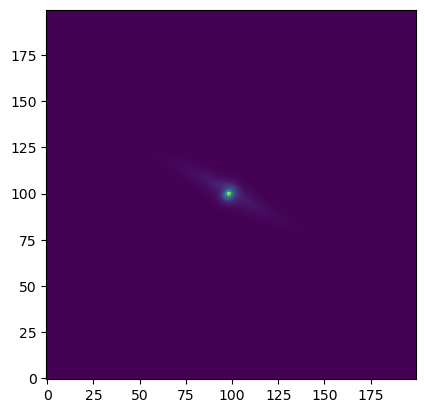

In [22]:
#image_g.shape
plt.imshow(image_r_1, origin='lower')

In [ ]:
high_reso_rgb=sharp_rgb_image(lens_class=lens_class, rgb_band_list=rgb_band_list, mag_zero_point=27,
 delta_pix=0.2, num_pix=200)

In [ ]:
plt.imshow(high_reso_rgb, origin='lower')

## Initiation of Butler

Here we initiate butler and take a cutout of the DC2 data where we inject randomly selected lens.

In [23]:
gsobj_r=galsimobj_true_flux(image_r_1, pix_scale=0.2)
gsobj_g=galsimobj_true_flux(image_g_1, pix_scale=0.2)
gsobj_i=galsimobj_true_flux(image_i_1, pix_scale=0.2)

In [8]:
config = "dp02"
collection ='2.2i/runs/DP0.2'
butler = dafButler.Butler(config, collections=collection)
skymap = butler.get("skyMap")

# Near the center of DC2
ra = 62.541629   # degrees
dec = -37.852021 # degrees
point = geom.SpherePoint(ra, dec, geom.degrees)
cutoutSize = geom.ExtentI(201, 201)
#print(cutoutSize)


#Read this from the table we have at hand... 
tractInfo = skymap.findTract(point)
patchInfo = tractInfo.findPatch(point)
my_tract = tractInfo.tract_id
my_patch = patchInfo.getSequentialIndex()

xy = geom.PointI(tractInfo.getWcs().skyToPixel(point))

bbox = geom.BoxI(xy + cutoutSize//2, cutoutSize)

coaddId_r = {
    'tract':my_tract, 
    'patch':my_patch,
    'band':'i'
}
coadd = butler.get("deepCoadd", dataId=coaddId_r)
coadd_cut_r = butler.get("deepCoadd",parameters={'bbox':bbox}, dataId=coaddId_r)

In [9]:
coaddId_g = {
    'tract':3638, 
    'patch':27,
    'band':'g'
}
coaddId_i = {
    'tract':3638, 
    'patch':27,
    'band':'i'
}
coadd_cut_g = butler.get("deepCoadd",parameters={'bbox':bbox}, dataId=coaddId_g)
coadd_cut_i = butler.get("deepCoadd",parameters={'bbox':bbox}, dataId=coaddId_i)

In [ ]:
afwDisplay.setDefaultBackend('matplotlib')

In [ ]:
fig = plt.figure(figsize=(10, 8))
afw_display = afwDisplay.Display(1)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(coadd.image)
plt.gca().axis('on')

## Cutout from the DC2 data

In [ ]:
fig = plt.figure(figsize=(10, 8))
afw_display = afwDisplay.Display(1)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(coadd_cut_r.image)
plt.gca().axis('on')

## Inject the randomly selected lens (we have already selected 
## a lens above).

## 1. r band

In [42]:
## This is a function which takes a simulated lens (in the form of gsobj) and injects in a dp0 cutout image
def injection(coadd_image, coaddId, gsobj):
    wcs= coadd_image.getWcs()
    bbox= coadd_image.getBBox()
    x_min = bbox.getMinX()
    y_min = bbox.getMinY()
    x_max = bbox.getMaxX()
    y_max = bbox.getMaxY()

    # Calculate the center coordinates
    x_center = (x_min + x_max) / 2
    y_center = (y_min + y_max) / 2

    center = geom.Point2D(x_center, y_center)
    #geom.Point2D(26679, 15614)
    point=wcs.pixelToSky(center)
    print(point)

    image = butler.get("deepCoadd", parameters={'bbox':bbox}, dataId=coaddId)
    mat = np.eye(3)
    mat[:2,:2] = wcs.getCdMatrix()

    transform = Affine2D(mat)
    fig = plt.figure(figsize=(20, 18))
    arr = np.copy(image.image.array)
    plot_extents = 0, bbox.width, 0, bbox.height
    helper = floating_axes.GridHelperCurveLinear(
        transform, plot_extents, 
        tick_formatter1=DictFormatter({}),
        tick_formatter2=DictFormatter({}),
        grid_locator1=MaxNLocator(nbins=1),
        grid_locator2=MaxNLocator(nbins=1),

    )
    ax = floating_axes.FloatingSubplot(fig, 132, grid_helper=helper)
    ax.imshow((arr), vmin=0, transform=transform+ax.transData, origin='lower')

    fig.add_subplot(ax)
    print(point)
    _add_fake_sources(image, [(point, gsobj)])
    inj_arr = image.image.array
    plot_extents = 0, bbox.width, 0, bbox.height
    helper = floating_axes.GridHelperCurveLinear(
        transform, plot_extents, 
        tick_formatter1=DictFormatter({}),
        tick_formatter2=DictFormatter({}),
        grid_locator1=MaxNLocator(nbins=1),
        grid_locator2=MaxNLocator(nbins=1),
    )
    ax = floating_axes.FloatingSubplot(fig, 133, grid_helper=helper)
    ax.imshow((inj_arr), vmin=0, transform=transform+ax.transData, origin='lower')

    fig.add_subplot(ax)

    ax = floating_axes.FloatingSubplot(fig, 131, grid_helper=helper)
    ax.imshow((inj_arr-arr), vmin=0, transform=transform+ax.transData, origin='lower')

    fig.add_subplot(ax)
    #fig.suptitle(repr(coaddId))
    return fig.show(), inj_arr, arr

(62.5277017829, -37.8407981636)
(62.5277017829, -37.8407981636)


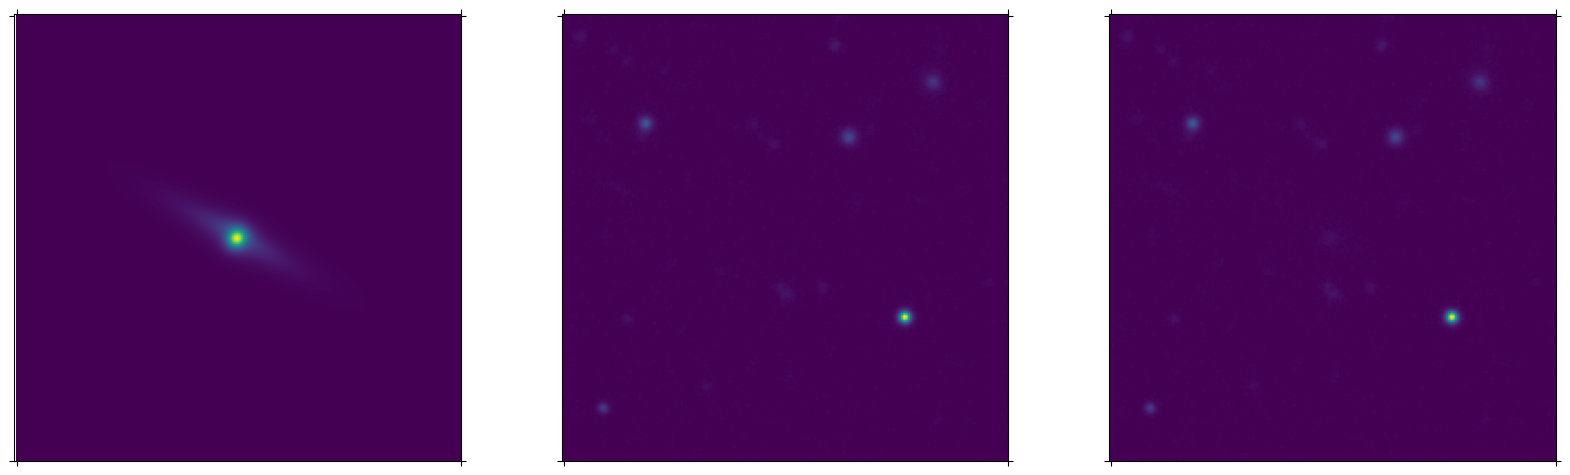

In [35]:
injection_in_r_band = injection(coadd_cut_r, coaddId_r, gsobj_r)

## 2. g band

(62.5277017829, -37.8407981636)
(62.5277017829, -37.8407981636)


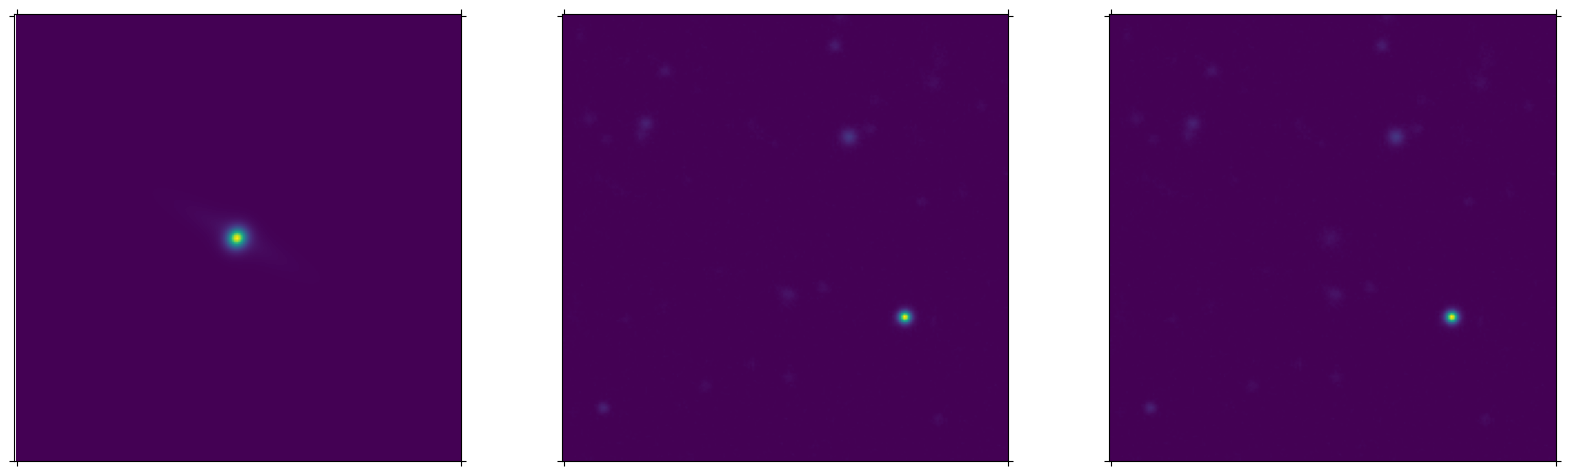

In [36]:
injection_in_g_band = injection(coadd_cut_g, coaddId_g, gsobj_g)

## 3. i band

(62.5277017829, -37.8407981636)
(62.5277017829, -37.8407981636)


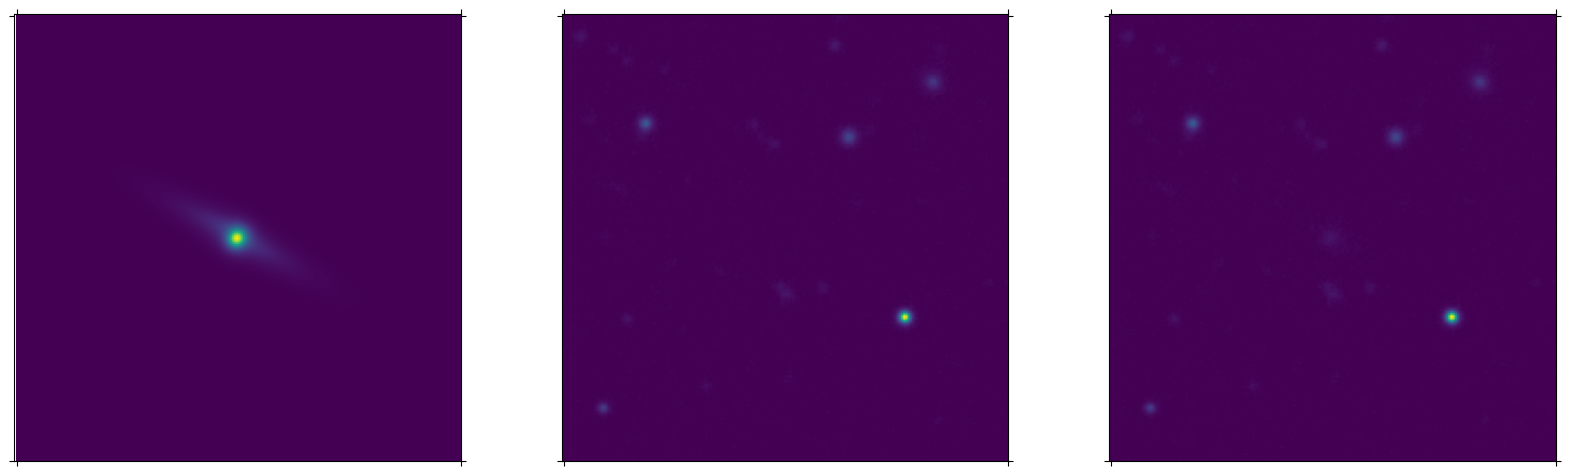

In [37]:
injection_in_i_band = injection(coadd_cut_i, coaddId_i, gsobj_i)

## Create rgb images

In [38]:
inj_arr_i = injection_in_i_band[1]
inj_arr_g = injection_in_g_band[1]
inj_arr_r = injection_in_r_band[1]
arr_i = injection_in_i_band[2]
arr_g = injection_in_g_band[2]
arr_r = injection_in_r_band[2]

image_list=[inj_arr_i, inj_arr_r, inj_arr_g]
image_list_1=[arr_i, arr_r, arr_g]
final_injected_image=rgb_image_from_image_list(image_list=image_list, stretch=2)
final_uninjected_image=rgb_image_from_image_list(image_list=image_list_1, stretch=2)

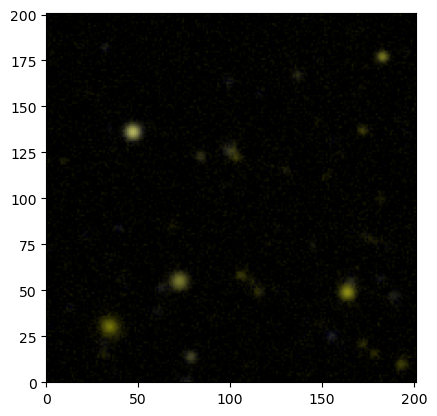

In [39]:
plt.imshow(final_uninjected_image, extent = [0, bbox.width, 0, bbox.height])

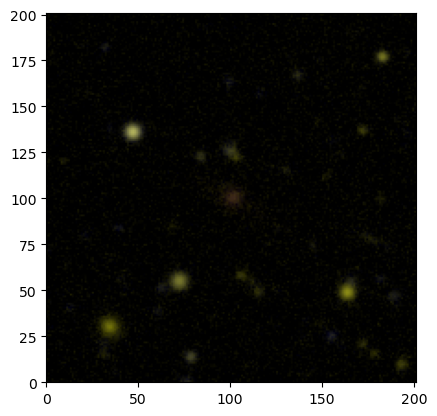

In [40]:
plt.imshow(final_injected_image,extent = [0, bbox.width, 0, bbox.height])

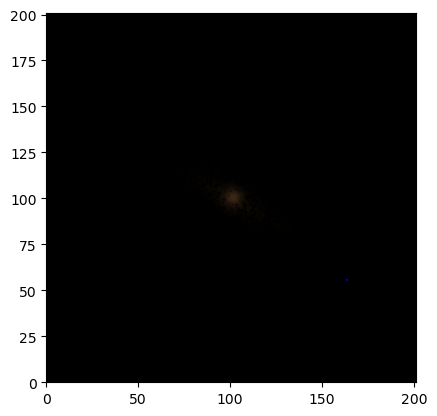

In [41]:
plt.imshow(final_injected_image-final_uninjected_image, extent = [0, bbox.width, 0, bbox.height])

## Instead all above process, one can simply call RSP module 
## from sim-pipeline and do all aove process

In [ ]:
ra = 62.541629   # degrees
dec = -37.852021 # degrees

In [ ]:
y=rsp.lens_inejection(gg_lens_pop, 201, 0.2, butler, ra, dec, flux=None)

In [ ]:
## This line should display an astropy table containg lens image,dp0 cutout_image, injected_lens 
## in r, g, and i band and  center of the dp0 cutout images.
y